In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


# Data loading

In [67]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
#df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

# Data partioning

In [68]:
train_val = df_dev['train'].train_test_split(test_size=0.09, seed=0)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1674
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 166
    })
})

In [69]:
df_train = train_val["train"]
df_val_ = train_val["test"]
#df_test = train_val["test"]

In [70]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val_ = df_val_.rename_column("comment_text", "text")
df_val_ = df_val_.rename_column("conspiratorial", "labels")
#df_test = df_test.rename_column("comment_text", "text")

In [72]:
df_val = df_val_

In [17]:
df_val_ = df_val_.train_test_split(test_size=0.09, seed=0)

In [18]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 386
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 166
    })
})

In [19]:
'''df_val = df_val_["train"]
df_val2 = df_val_["test"]'''

In [20]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1288
})

In [73]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

In [22]:
df_val2

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

# Model loading

In [74]:
nome = 'BERT_ita' # modificare
model_name = 'dbmdz/bert-base-italian-cased'

In [75]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [76]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [77]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
#tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Training

In [78]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=9,
    load_best_model_at_end=False, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=0
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [79]:
config = AutoConfig.from_pretrained(model_name)

In [56]:
# config.dropout = 0.001

In [80]:
print(config)

BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}



In [81]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [82]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [85]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [86]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.564800,0.498434,0.714777
2,0.429600,0.508444,0.770092
3,0.248300,0.915073,0.799978
4,0.126900,1.268075,0.776711
5,0.050500,1.310844,0.789088
6,0.033000,1.323472,0.801024
7,0.006700,1.351185,0.794704
8,0.003500,1.379254,0.806216
9,0.002600,1.394490,0.800328


CPU times: user 24min 9s, sys: 14.9 s, total: 24min 24s
Wall time: 25min


TrainOutput(global_step=1890, training_loss=0.16287777370245998, metrics={'train_runtime': 1499.5588, 'train_samples_per_second': 10.047, 'train_steps_per_second': 1.26, 'total_flos': 3964031160053760.0, 'train_loss': 0.16287777370245998, 'epoch': 9.0})

F1-score maggiore: 1° epoca.

Loss minore: 1° epoca.

# Evaluation

In [87]:
log_history = trainer.state.log_history

In [88]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

<ipython-input-88-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-88-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-88-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-88-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [ ]:
#df.to_html(f'loss_{nome}.html')

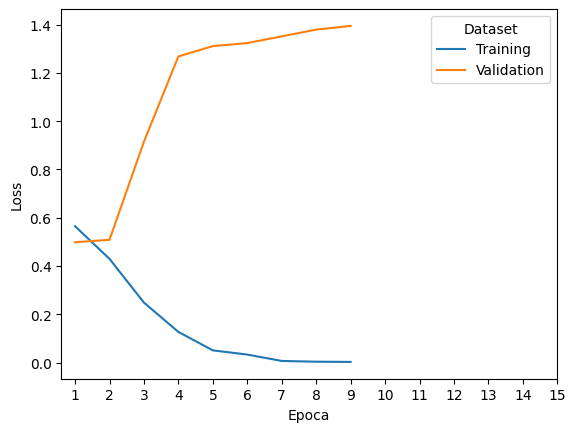

In [89]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
output_predictions = trainer.predict(tokenized_val)

In [91]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        86
           1       0.81      0.76      0.79        80

    accuracy                           0.80       166
   macro avg       0.80      0.80      0.80       166
weighted avg       0.80      0.80      0.80       166



L'f1-score sul secondo validation è dello 0,66, mentre sul primo era dello 0,75788 :(

In [ ]:
with open(f"class_report_{nome}_doppioval.html", "w") as file:
    file.write(report)

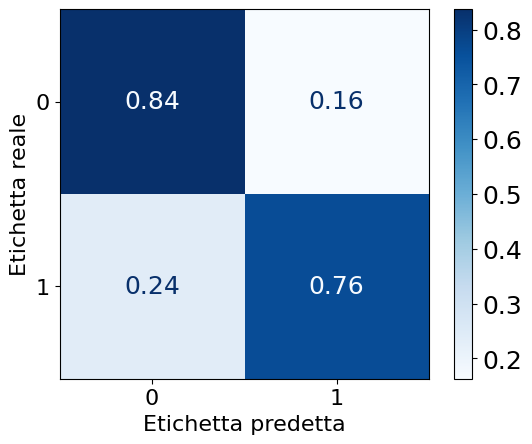

In [92]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [94]:
df_val = df_val.to_pandas()

In [96]:
df_val

,text,labels
0,Vai al ristorante e ti ritrovi la polizia che ...,1
1,Il vertice del G7 si e' svolto nell'ideale e c...,1
2,( distraevano il popolo con il teatrino dellel...,1
3,Joe Biden non riesce nemmeno a mettersi la sua...,0
4,Vi ricordate quando Filippo già ( Allora le su...,1
...,...,...
161,"""Colleghiamo tutto a internet, ospedali, centr...",0
162,Prima o poi il karma farà il suo corso!,0
163,AZIONE: Fate il vostro meglio per sostenere il...,0
164,"]( ""Association of Vitamin D Status and CO...",1


In [100]:
def error_analyze(df, y_true, y_pred):
  df_errors = df.copy()
  errors = dict()

  for idx, value in enumerate(y_true):
    if value != y_pred[idx]:
      errors[idx] = (value, y_pred[idx])
      print(df['text'][idx], (value, y_pred[idx]))
      print()

  error_idx = list(errors.keys())
  df_errors = df.loc[error_idx].copy().reset_index(drop=True)


  return df_errors

In [101]:
df_errors_val = error_analyze(df_val, y_val, y_val_pred)

Vi ricordate quando Filippo già ( Allora le sue congetture ci sembravano fantascienza, eppure da come si stanno evolvendo le cose abbiamo le sensazione che sia proprio questa la direzione. I britannici sono stanchi della monarchia (in realtà sudditi dei Rothschild) e vogliono una repubblica.   Poche ore fa, mentre l'élite rende omaggio alla regina della Massoneria e della Cabala nell'ipocrita passerella di Westminister, i tifosi del Celtic - una società calcistica britannica di Glasgow affiliata alla Federazione calcistica della Scozia -, cantavano a squarciagola:   "Se odi la famiglia reale batti le mani".  E a cantare e battere le mani è lo stadio intero a cui si sono uniti persino calciatori e dirigenti. Un'epoca è finita e una nuova sta per sorgere! Filippo ricevi la nostra immensa stima per averci aperto gli occhi in tempi non sospetti. (1, 0)

Ma voi avete trovato un partito che sia contro l'aggressione russa in Ucraina E anche contro la dittatura covid, che si possa votare doman

In [102]:
df_errors_val.shape

(33, 2)